# dAiv 인공신경망 특강: 정보의 인코딩과 디코딩

#### 들어가기 전에,
##### 이미지란?
- 컴퓨터에서 이미지는 픽셀의 2차원 배열로 표현됩니다.
- 각 픽셀은 색상 정보를 담고 있으며, 일반적으로 RGB(Red, Green, Blue) 값으로 구성됩니다.
- 컬러 이미지는 각 픽셀마다
    - 빨간색(R) 채널 값
    - 초록색(G) 채널 값
    - 파란색(B) 채널 값
    으로 표현됩니다.
- 이미지의 크기는 픽셀 수(해상도)로 표현되며, 예를 들어 1024×768은 가로 1024픽셀, 세로 768픽셀을 의미합니다.

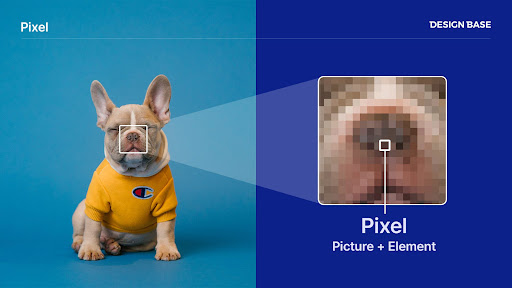

##### 이미지 처리와 압축의 필요성
- 고해상도 이미지는 많은 저장 공간이 필요며, 네트워크를 통한 전송 시 대역폭 문제가 발생할 수 있습니다.
- 따라서 이미지의 크기를 줄이거나 중요한 정보만 추출하는 압축 기술이 중요합니다.

## Imports

In [ ]:
from platform import system

if system() == "Windows":
    %pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu128
else:
    %pip install torch torchvision torchaudio

In [ ]:
%pip install --upgrade matplotlib tqdm numpy pandas scipy jupyter ipywidgets
%pip install --upgrade git+https://github.com/dAiv-CNU/torchdaiv.git

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import transforms

from torchdaiv.lectures.enc2dec import util

from PIL import Image

## Load Data

In [ ]:
from IPython.display import HTML, display
from base64 import b64decode
from io import BytesIO

image_data = """
data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAkGBxISEhUTEhIVFRUVFRUVFhUVFRUVFRUVFRUWFhUVFRUYHSggGBolGxUVITEhJSkrLi4uFx8zODMtNygtLisBCgoKDg0OGhAQGi0dHR0tKy0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLSstLSstLf/AABEIALcBEwMBIgACEQEDEQH/xAAbAAABBQEBAAAAAAAAAAAAAAADAAECBAUGB//EADsQAAEDAQYDBgUDAgUFAAAAAAEAAhEDBAUSITFBUWFxIoGRobHwBhMywdFCUuFy8RQjYpKiFTNDguL/xAAYAQADAQEAAAAAAAAAAAAAAAAAAQMCBP/EACERAQADAAIDAQADAQAAAAAAAAABAhEDIQQSMUEiMmFR/9oADAMBAAIRAxEAPwDX+Qi06IhANYqXzzC7UEzSCc0QotkpxTckBKLAFKo8aILWFT+QSkZhCiBJyRhQT1KRDS7gCVm1sjRFdlMWR50g9CPRMyW6ghcFab6rMe6Hb5K3Yfi+oCMZxCRiB4brjr5c/sOufFj8l2fzExeU1htFOtmw67cDuFebRAXXW8WjYc00ms5KiWkpi0rS+WndR/hPS9Wf8pEZQkK6KSmKaXsfqzX2NJllWkGJCmjR6qTaCMaOSsimpYUtGKLaSl8pW8IQyjRiv8pTDURqm5wAkmANyjTiATTUXQNSubv34sa2WU/Fcy74nqE6rmv5OdVjXTTx97t09HpvBMBTc1cr8L2173FzjquqxqvFyTeuyly0ilsJrJS+WnFRMXqqZnNTQmehklAEapShBRcTKAsJIYcUyAp/4VSbZVewJALWjFdlIBTgKRSASBvlp200ViJhSAYooF6dmk49yuAqjfp/yXKfJ/WWqf2h5PfGp71kkOObfBaF9O9SFQprgzp3frUuS/X0agB0cMxOsDUcD+V6XdPxDTe1ofPa0fv/AOw0XjFsYdW7Gei1/hu31WjH9TGmXAZuYNcQbqRrIG3ctRNq9xJWrFupe4NblkQQdCNCiYcunof5XM3Lekx2gWuaHtiC0jcjkujs1cEkLory79c1uPPggaCeuvVQcUeyjT370VV+sKsSnMEHKQUC1IBaIvmJSfBOGIop9klKZGIObqghu6tVPtHgse8bfhGX1F2EfnuU7cnrDdabOJXheDKQlx7lwXxH8Wl8taYA4aLY+I6Aqw0vwtaJe7iBt1PkvNrRZnvcSGkMBME5dnY/dct+S15yZyHVSlaxsfTutZdpnuT1TMcQQiUaIbpoqtpcJHVKKtzL0L4Rfie0DRd58tedfBNb/MHh0XpS6PGn+MufyI/kr4EsKNhQ3hdGoIlqgWIzVEoAYCfCiAJQmQWBJEToADa6arU4JmsU4TJCgSjFqiwIgRp4gGwiYkk0JaMJwKyPiG04aZaRqMj9ltgLn/i6xEtBEmOWihz2yinDXbPLr1Jgwd+MqmKuQGqu3szMg6z0PmsezEl+HATwAmVy0+Oq/wBbV20XBweWYm79FvWiw0nAOYBSqfpqMyE7Yh7BQrustVjRhLsxmyo2fMKwCZORaTqDm09d/XqFv1Y9gvhq3OFT5TgGua/Fh0ALv+6G/wClwOMDiCvQrPULXsO04fNcNY7spvr03uL2FpGbQHNIPPce+vo1a7HOEsIcG6YdRHJaiOmZntqDJvNVSxXmskA7x3LOtFkruMBsAHWQq1tEJTBBwT0zJyVujcpjN2fvRPZrseHHKRCfsWKxY5HoDskFWatndEYdtkHtMAJacvGN1m1ujiO1S3HDi/pcfD+64y1WiagM5MaXeJhvkCe5dleljc8fUGggiTqQY0G5yXD3xdFomKbXQ4y58RhaMhAOp/uue/tK9PWGLb7S6s/ANAZfwHBp49NzyGYrS6i0QQarhtMMaeLvZVn5LWNwDsjfiTvmfVPZ7I39jnxoA0hgPMnfmsRXvZUm3WQ5e1A65Achl3LFe6X5Ad4XXX/aHNywMaOMk+Yk+a5Rhxv27pPmqT8Zjt2fwlWwvnp7heoWd+JoOS8quGiSBG5XqV2ZUwIAA5a80/Ft+M+TH6sgJOCeUiuxyhBMSpwoEJgpUZSTFMilJRlJMEAnAUw1MQshEBT0SBUkAgnwJKQKAdjYWdegDtXEea0hmse96mUQFy+T1Do4Przv4nsJBJyPMZgrn7ou9wfjIeGDgAB/yPoF3lppNdkWmfH8qxZrA05imSf3EER3u/ClxQrySxmWuIAa6Nsy7yBAWjZpd/43Z8RHlBV42XB9TmMHBsEnwEItGu1v6e9xElW+I7ol30XtM4XEcCBB8l1lhtJPabkd2n7HVYdgvUA50yegdHouisdrpv2wngfsloxpMqBwDhkfXkfyjvaC3EN9RwWYQWGdWnyVyy1tRx8EyWqL+yPBEa+JVIPgFE+Z76BMk6tTOFXc3PiU1N0klNUtAGnvr+EA1ZpGep95SsC8aFZ2zG9S6fELYLnHPTnHpsEGpT/q7yR6LTLkbTc1QnFiA4luET1cVTr3bH1/O6jF6hy6i13eDmC5p5HI9Rv3hc/aLH8qYb30y5p/2zHgszRuLuTvy5qTmksxYti97p83GVytlsoxRixGf2QO4zmu6vbBVGEVH4htJIP9RaAe6VSuq5GMMuqAno37SocvzHRxf9lofD1jgAbb/wASu+pgBjcolYV22ZojtCPDzXQV2DC2PGfsn40ZLPkTsBF0KLnqJqJELucaReouUHBRqPgJhOUxKGxyclMESknTIAxcnBQMWakFkDAJFOxM5AOAiNQqZRQgHJWZbg0ytEhZdspnbNQ542qvFOSw69IySHAdSfsEF9YjJ1buaCXd2w9Vo2qytAlzvT35rLrWxjPpE8miJ6lQpPqtaNKnZyT2QGg5yZLzzk5+ELasFhaIyk8XLOu9xd2iInMN+54963rE0HeOPE9+ypqbSstnP7h0hx9FdbZJ2J6Ej1CHZA3Rpk/1TH4Vs03/ALvOfIplpmEgQc9ocI/5BMezmPp4bhENc/qEqLiNvDZMk3unvCes/Xnl6Ktjju9EOtXzA6nxKUycQsOqbAwOKNRpDWO92vgqQrBuuvp0R6dcn+UotAmB6r+B/KqVGv8A9J6yrIqzw7lEgHPzVIljFAl20c+H5Cq3jYhVaYOF+3A9Vo16QOfnoR3rOr1TT5jdaJx1a5Ycfma89O8A59UejdYOtWR+0Q0flbF52kkDCddDhxRyIVezUiT/APJAXNfj7dNeTpbu+yMaR7HotW0RkBpChZKZAzAHRQrug5KvDTEuW+hvU2tQ8cqXzV0oncxQLFKUzygBOakpEocoB8SSikmQqkCh4k6yYwKeVXpI4QD4gFEPSLU+iATZVS2TOnT+yuY0zo1WbRsYcTkuetVlc+TB6wqBsLWmfqI3OgXQ2hxcYGQ95lVLRQy4MGp0krlmsQvFplTszJyBzPkt67aDQe0fGM+qxrKJBOg+wQLVeAaZBjyWZtEHFZl6FTqACAR0TGr07jPlquAsfxQBkSD0gHuB1Wn/ANXLxLSHjcQA8dRIlUraLfGZpMOitFcamRzH3VCpbYOv8rk7Xeb8y1xHEZ5HgWmCPBDo3g57ZPXw/hYtZutenYi2gqFW0wZnYLnG2wgDmR6FNaLad+A+6xMzjURDe/xWfMqZt4GU5rmRbSJPLzQGWv8AUddB+UoOYdcLzEa5eqtUL0xZae+P8Lh324DfRW7BeYJ+oeIWq37ZmnTvWObGufHWOkqnbaRw8eg+yy7Nbx+0nnM+crUo2kHiPfRdEWRmuManTl0Ekc4nyWmyz4Y7WLuRnUmHMQChFsLVa6zMlXtMBUadQuKsVWYlXEtcqxDCyKYCBW1R5TFqYCNSBKiyqHIlRuUKuylCAlVahU3FEaTKm5oTI2FJLEnQaIRGoWSdj1kJFSpuQ3vU2BANXqkaKdN0jNIQU7kBJpU3BBLlIOQEgwDhKybeHO10HgtWFCq8QclO1darbHN2uvgYBpuVydvtTnEwDC6y8oIJGsxp5Ln6lDPb30XHyV7dXHbpxV9Wh4cAC4ZgknQ5xotK7r3qNaXF/wBM6/WY1Efq81a+IbpNRuJozG2WYXLMovkTkRvBxZcctVbj9c7jU+T23p2Fn+IG1BiDsspnIicpW7YHTpvM++q4KwOAfJYTscOrgdiIy49y9AueC0FrMJ/acv7LMcff1qb9fBmkyGniE16E4Z3JA71fbQD4dEFpz6R/CsusIe0DgZ314/ZamsYxFp1zDbVGKdBuq1rtmAEzstq8brDQR45eUnILkL4s5qNOFzdx9bco2gKUccq+8Kdotj7TLKb4wxiOeczGc5BUrpvCrSqBrnS0znnHZ36KqLvfM4ATvhIInvjyWxc91l9UYx9PgB+SuiaVimZn+oxe03+u4ua9Dv4ggg9V01jqzoSDwC52z2UbRHot666Iy35qNYlS+NljzHPmEolEp2ZxiIjmUKs0tdHouurmkxyUCpOCbCtEcFRe5PIUSQgIuUcCkExTAJMFSKc00oQA4SRhTSTCuGqQAQsZRWhZBjTlEGShiUyUBJiaog1Z2QfmnRAWJRmAqqWHVWGVckgM54CDaIiU9UAoVQZIDDtI146wsWvTjMrctFPtkjQLLtrJB3nh0XNy1/V+KfxjvrAc+vhlwTtDHagTxRm2OcoPUwB5q1ZrCAe03uXPG66JzHPOsADsLcUvknCJdEzHTRdTc1iLIkOHNzY7pG3VadjpN3DR74LTYBGRHSFaspWVKVSHTywuHofBXjVDANOZ3jgOqz7ZUA5H1G4RbteKhDpngOuZIVc6T0O30fnAktdEZA5Nj2NVx9tuo06oP1NMxkBnu0xuvTnWEuzjxPqsu8Lqp1AWntf0z67fwifh1+uLbdNJx0HEHJaNGwxk3CD/AEie+CtF10OGUGNp1HejU7qOW/cQQpfy+KbEdhWO7ic6jyR+3IDw3710NnbAyEBCsdmI4nrsp2iqJjFJ4Dbqq1rkI2tstJjjhkZcwqWIz15yq7qrnGJy4IwKtEYlIoKGSncYUSUwk2FEAIZSqaZICZKYlC2SL0wIXpnFVqjTOSmCUwJiTpApICtVfwUWViNU7cincAVkGbUzVjEhYAnY5AHMQmY0KQhDISNN7VAtUwmQBCwKAppwUsaRMi9AGA5xKxY7MgzzWr8SVwAMR/uudsrsToDQJ/dJP+0fcqV41Sk4sNdHXzU6dqcNj4A+soVttLacgAA9w8Ssl9tcePoPErktMOusS3q3xA2kO00E8IaD5BApfEYdqzB4x5fhZAqhwjsk8pPi469ywL3vI03gNAyBJO54LdNmSvkQ7C8LzxCZ5gnePXrr4K7cNtAEyNeyNehI39npxVhvLGwDENO1kBPKI996MLyc1obikbAwe6Cu2K645s9CvK93tHafPIxPgThb3qd3W551IA1j6iZ359VwtivV1Wabu02JAEDCd4Wzddb5fZJ7O3Fh/Hvrzcu1ti/Hlqu5+e4jSfD0Eoba+xgHaZH91Uo1XBoM4uhifFDdap7Lma5dofeEvbOxmtWTGp98tFluGHPnxz6rQsb5ZhEgjSZzHUDPyWfVpuOROEnoQffIro452ELxktKyEHNHqBUbrBgg7K49UYhIFQehl2ylsg0gQouKQGSZAQDkmhO6EpQDFMckiUwMpgyZMWpIBioSnxJMSMXBko/LUnPU3DJIIkqZGSA0opKAIEjmEMuyUmjJIJU8kn1QFBpVW8KmGm50Zxl3oDl77tAdUJJxEZA7dGjYezKHdjA90wYGfAflUKrJkkp7FVIcNcP7Tv1H2UdbwW3uaDkBnpsOqoOwDMgchHnKvXhDjin3w6rHqntZ6bDM6aLltHbspPS3UrtGcbTGnesG/LE57fmjYQcsss0W02vszrPv33JWO1BwwOzBAnvErfFsT2xyxsdMG7Q5riSQWwfypXjRe5wIIAMRJ8yr1pupoH+S4yZyOgGwnfZEpXS0DHUeSW/p20JHmD4LqjHLk/F+4bEWAucTMe497LorE46wHDnkenJYLbZmANJ+/vwK3bMAc2nXUephc/Jb2l08dfWGzYa7WfSXM5aDw0K0mXw4DtgEfuaI8QPsubdTqDMObHAiZ8Cr9hpnDJAnlKxWJ3IO0xmy6Ojag2HYsjlt4hUrVeXzCYAyOeWqyScQiIg+qtWOzESeJ33XfSmR24r32emxdtTWffIq7KzLFRImTEjKNeqttcYzieSAK8SlKQUPmJmOwqFQJ8QUKlTZBISkDKGwKQMJg7zCjKUymlAIpKGNJMjtanTYlKm+NVlozNUQv2QjUB0KgUgc6qTVEOUqZG6QFKYPhRcUxhAFOap3uYpHmrLXKpbWk5HRYt8Ov1yzqUjMKBoLSrsGirvYowsy8IMhwnPJULTdzyZaZzyhbb6CqNeRI0zTmkSK3mGELpJIz7lbs/w8P3HPeY8IW7QY0jtCY8VKpVY3jrCdaYLcmudtPwySRgqGBnBnu095JUfhpwnFUO+mevXoF1kQ0RvPkq+M4gBnOv3WrTnTNY3tzD7mMQ0mBz0235K1SoPbqehEg+S37PZZnb7qxZ6OGZzzy8B95U44plSeWIZljc+QOO516SFvNtDmjtZ+RWfjwuyA8ERzy7XircfFMfUb8sT8WGdrOVo0Gk7rOsbS1btlYCJCujhrNS7Uzn5IrmqZwg9o9wTOdHRY/WvwsSemQhB6ROa0BnOQ6j5SUSEBKm5O7goVGwk1yAZzIUS5SdUkqDolOCFbhSVeEkyO4KFVpIhOkpy2jQs4YEQlMkkBWDJMkkgI4s0WQkksmWJQc6dkkkEybXREqp/hpSSUsUiUalKFn2qgkkmRqJVj5I39lJJOokdpyyTWej25J4wNgnSVIj9YmRDUjIKDamqSSW9jEQ39SPZqU5p0lSPjEtGlT2hWaDHN6JJJScSsUGAuzRarIEhOklBqdN53RXFJJbIxUXkwkkgIVHGFAApJJkcGUVjBCSSAGQkkkgP/2Q==
"""

raw_img = Image.open(BytesIO(b64decode(image_data.split(',')[1])))

html_img = f'<img src="{image_data}" width="500"/>'
display(HTML(html_img))

##### 이미지 전처리

In [ ]:
# Set Image Size
IMG_SIZE = 128  # 이미지 크기
BATCH_SIZE = 4  # 배치 크기

# Image Transformation
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),  # 자동 크기 조정
    transforms.ToTensor(),  # 텐서로 변환
])

img = transform(raw_img)  # 리사이즈 및 텐서로 변환
img = img.unsqueeze(0)  # 배치 차원 추가
img_batch = img.repeat(BATCH_SIZE, 1, 1, 1)  # 동일 이미지 4장 생성
img_batch, img_batch.shape

## Practice - Encoding and Decoding

### <대조군> 인간 관점에서의 이미지의 정보량 축소, 복원
- 핵심: 우리 눈이 보기에 적당히 티가 안나야 한다.
- 우리 눈은 의외로 멍청하다.

[참고자료]
<iframe width="560" height="315" src="https://www.youtube.com/embed/tHvZngU14jE?si=jVh89IesB3wdIa4Y" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture; web-share" referrerpolicy="strict-origin-when-cross-origin" allowfullscreen></iframe>

**이미지 보간법(Interpolation)**

주변 픽셀 값을 기반으로 이미지의 새 픽셀 값을 추정하는 방법론
- 주변 픽셀 값을 선택하는 방식에 따라 NEAREST(가장 가까운 것 선택), BILINEAR(거리를 반영하여 가중 합) 등의 방식이 존재

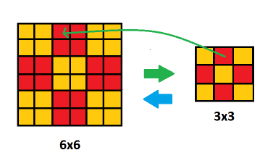

**풀링(Pooling) 연산**

컨볼루션 신경망(CNN)에서 사용되는 중요한 연산으로, 이미지를 축소하여 중요한 특징만 추출하거나, 계산을 효율적으로 처리하는 방식



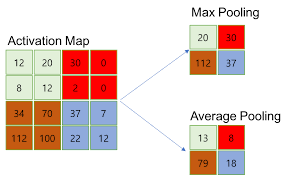

**컨볼루션(Convolution) 연산**

이미지나 신호 처리에서 특정한 필터(커널)를 사용하여 입력 데이터를 변환하는 방식
- 평균 필터를 사용하면 이미지를 흐리게 만들 수 있습니다.


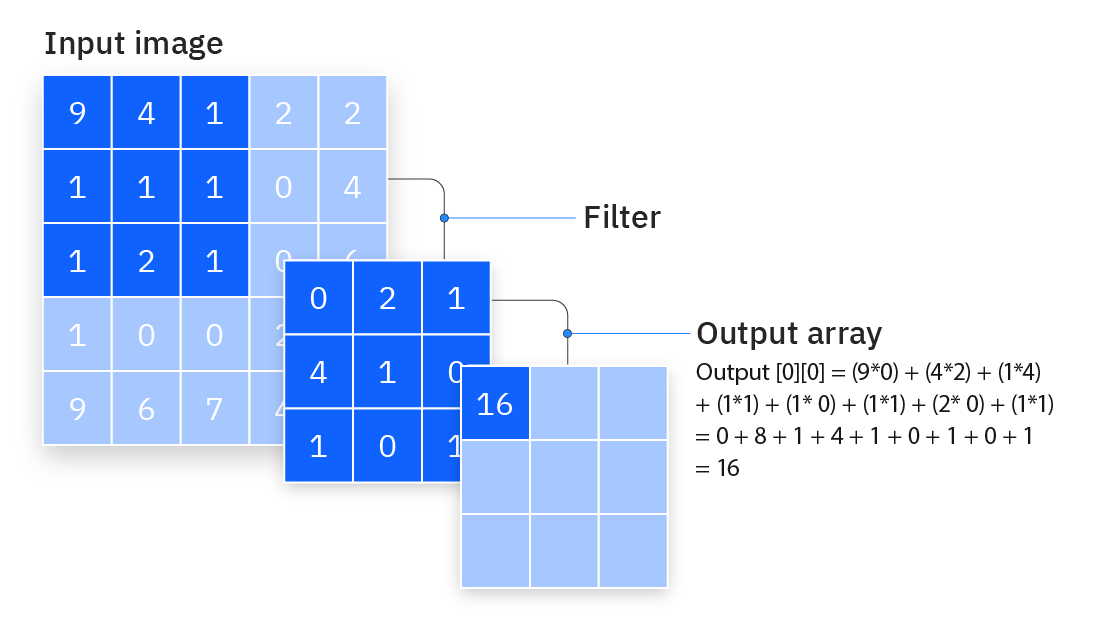


> 이 실습에서는 4가지 인코딩 방식(Nearest, MaxPool, AvgPool, AvgFiltered)과 1가지 디코딩 방식(Bilinear)을 다루게 됩니다.

#### 인코딩
- 정보량 16배(가로4*세로4) 축소 태스크
- 우리는 어떤 방식으로 하면 크게 형태가 무너지지 않으면서 사람 눈이 인식할 때 최대한 유사하게 보일지 이미 알고 있습니다.
- 몰랐더라도 눈으로 보면 바로 확인할 수 있죠.
- 이미지를 더 작은 크기로 줄이기 위해 단순히 픽셀을 선택(절반으로 줄인다면 값을 2개씩 짝지어 그 중 하나만 고름)할 수도 있겠죠?
- 그런데 그렇게 한다면 픽셀 값 차이가 커져서 상대적으로 부드러운 정도가 감소하게 됩니다. 픽셀이 눈에 보이게 되는 문제가 발생하는거죠.
- 이런 경우, 우리는 선택해야 했던 픽셀들을 평균을 내거나 하는 처리를 하기도 합니다.

##### (1) Nearest Encoding - 가장 가까운 픽셀 그대로 복사

In [ ]:
class NearestEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoded_size = IMG_SIZE // 4
        self.function = lambda x: util.to_pil_image(x).resize((self.encoded_size, self.encoded_size), resample=Image.NEAREST)

    def forward(self, input, show=True):
        encoded = self.function(input)
        if show: util.show_result(input, encoded)
        return encoded


nearest_encoder = NearestEncoder()
encoded = nearest_encoder(img)

##### (2) MaxPool Encoding

In [ ]:
class MaxPoolEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.function = lambda x: F.max_pool2d(x, kernel_size=4, stride=4)

    def forward(self, input, show=True):
        encoded = self.function(input)
        if show: util.show_result(input, encoded)
        return encoded


maxpool_encoder = MaxPoolEncoder()
encoded = maxpool_encoder(img)

##### (3) AvgPool Encoding

In [ ]:
class AvgPoolEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.function = lambda x: F.avg_pool2d(x, kernel_size=4, stride=4)

    def forward(self, input, show=True):
        encoded = self.function(input)
        if show: util.show_result(input, encoded)
        return encoded


avgpool_encoder = AvgPoolEncoder()
encoded = avgpool_encoder(img)

##### (4) AvgFiltered Encoding

In [ ]:
class AvgFilteredEncoder(nn.Module):
    def __init__(self, kernel_size=11):
        super().__init__()
        # 평균 필터 (3x3) 생성: 채널별 독립적으로 사용 (groups=3)
        self.avg_kernel = torch.ones((3, 1, kernel_size, kernel_size)) / (kernel_size*kernel_size*1.0)  # [out_ch, in_ch/groups, kH, kW]
        
        padding = kernel_size // 2
        self.filter = nn.Conv2d(
            in_channels=3, out_channels=3, kernel_size=kernel_size, stride=4, padding=padding, groups=3, bias=False
        )
        
        self.filter.weight.data = self.avg_kernel
        self.filter.weight.requires_grad = False  # 필터의 가중치 고정

    def forward(self, input, show=True):
        encoded = self.filter(input)
        if show: util.show_result(input, encoded)
        return encoded


avgfiltered_encoder = AvgFilteredEncoder()
encoded = avgfiltered_encoder(img)

##### (5) 비교

In [ ]:
encoded_list = [nearest_encoder(img, show=False), avgpool_encoder(img, show=False), maxpool_encoder(img, show=False), avgfiltered_encoder(img, show=False)]

util.show_result(
    *encoded_list,
    labels=["Nearest Encoder", "AvgPool Encoder", "MaxPool Encoder", "AvgFiltered Encoder"]
)

#### 디코딩
- 정보량 16배(가로4*세로4) 복원 태스크
- 전통적인 방법으로는 손실이 이미 일어난 이미지에 대해 디코딩하는 것은 거의 불가능합니다.
- 최대한 디코딩이 잘 된 것 처럼 보이게 알고리즘적으로 시도해볼 뿐이죠.

##### (5) Bilinear Decoding

In [ ]:
class BilinearDecoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.decoded_size = IMG_SIZE
        self.function = lambda x: util.to_pil_image(x).resize((self.decoded_size, self.decoded_size), resample=Image.BILINEAR)

    def forward(self, input, show=True):
        decoded = self.function(input)
        if show: util.show_result(img, input, decoded)
        return decoded


bilinear_decoder = BilinearDecoder()
decoded_list = list(map(bilinear_decoder, encoded_list))

util.show_result(
    *decoded_list,
    labels=["Nearest-Bilinear", "AvgPool-Bilinear", "MaxPool-Bilinear", "AvgFiltered-Bilinear"]
)

### <실험군> 신경망 관점에서의 이미지의 정보량 축소, 복원
- 데이터를 기반으로 이미지 정보량 축소, 복원 (오토 인코더를 통한 자동 모델링)
- 신경망의 입장에서 최대한 중요한 정보만 유지한다는 것은 무슨 말인가? -- 직접 관찰해보자
- 핵심: 다음 신경망 노드가 정보를 처리하기 용이한 형태로 변환되는 것

[참고자료]

**오토 인코더(Autoencoder)**는 **비지도 학습(Unsupervised Learning)**의 대표적인 모델로, 주어진 데이터를 압축하고 재구성하는 방식으로 학습하는 인공 신경망입니다. 주로 특징 학습(Feature Learning), 차원 축소(Dimensionality Reduction), 노이즈 제거(Noise Reduction) 및 이미지 생성 등 여러 분야에서 사용됩니다.

오토 인코더는 입력 데이터를 낮은 차원으로 압축하고, 다시 원래의 데이터로 복원하는 과정에서 중요한 특징을 학습합니다. 이 과정은 네트워크가 입력의 중요한 특성을 추출하도록 유도합니다.

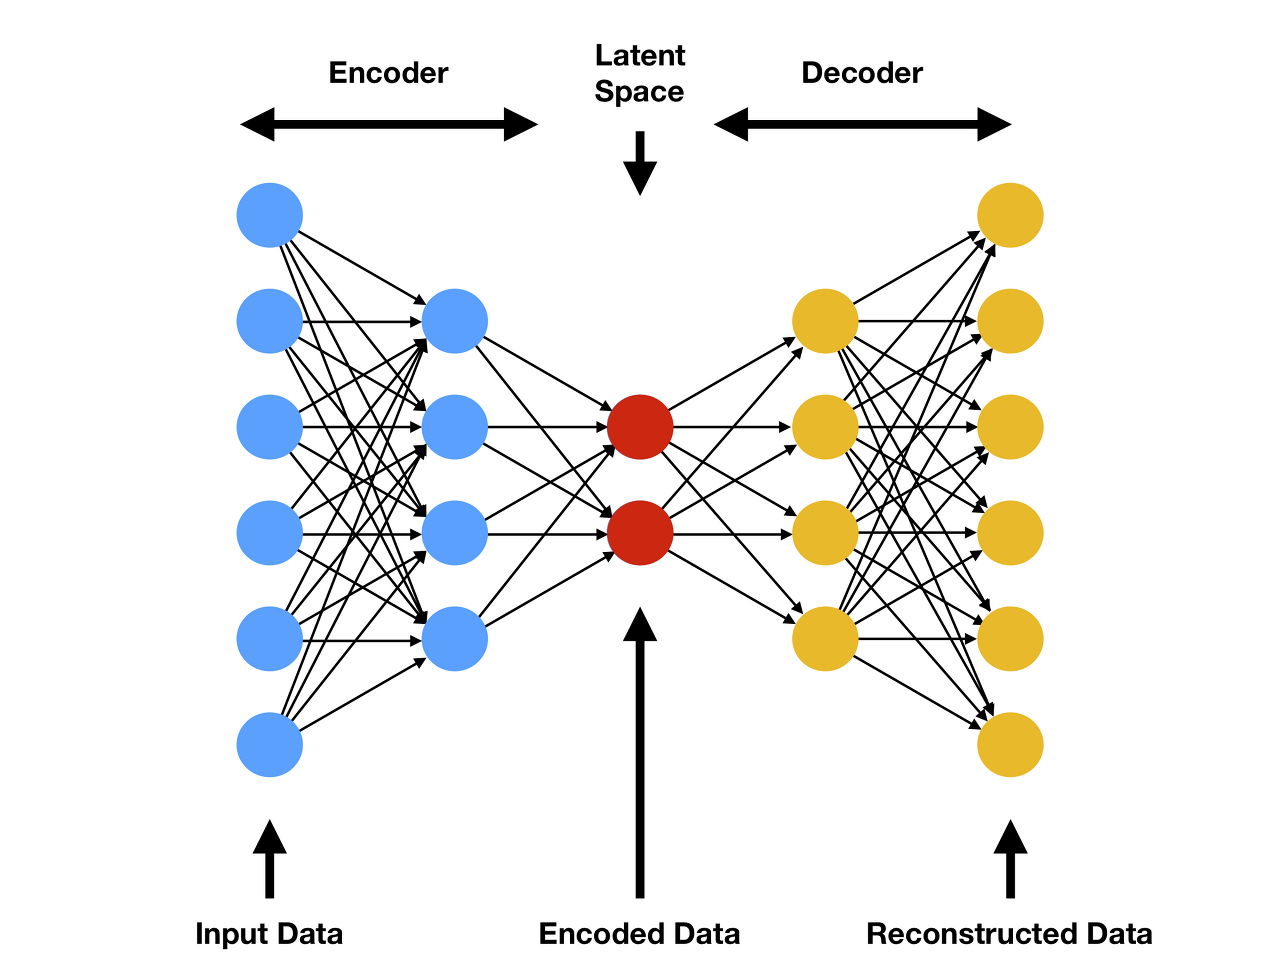

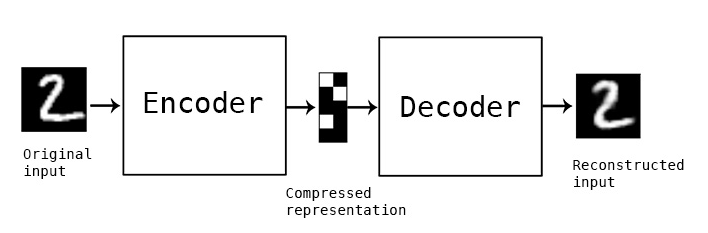

**DNN**

**DNN(Deep Neural Network, 심층 신경망)**은 여러 개의 **은닉층(hidden layers)**을 가진 인공 신경망입니다. 기본적으로, DNN은 **다층 퍼셉트론(Multi-Layer Perceptron, MLP)**의 확장 형태로, 여러 층을 거쳐 입력 데이터를 처리합니다.

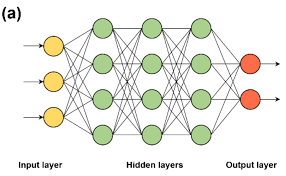

**CNN**

**CNN(Convolutional Neural Network, 합성곱 신경망)**은 컴퓨터 비전 분야에서 널리 사용되는 딥 러닝 모델입니다. 특히 이미지 인식, 영상 분석, 패턴 인식과 같은 작업에 효과적입니다. CNN은 전통적인 **다층 퍼셉트론(MLP)**과 달리, **합성곱 연산(convolution)**을 사용하여 이미지나 시퀀스 데이터의 특성을 추출합니다.

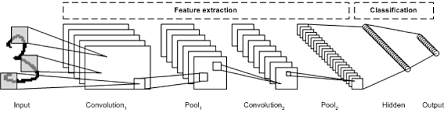

> 이 실습에서는 DNN Encoder, DNN Decoder, CNN Encoder, CNN Decoder를 결합하여 총 4가지 케이스를 다루게 됩니다.

> Enc-Dec 모델 형태를 사용하여 데이터를 기반으로 자동으로 모델링 하기 위해서는 인코더와 디코더를 한번에 결합하여 학습해야 합니다.

#### 오토인코딩

##### (1) DNN Encoder to DNN Decoder Model

In [ ]:
class DNN2DNNAutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.input_dim = 3 * IMG_SIZE * IMG_SIZE
        self.encoded_size = 16

        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.input_dim, self.encoded_size*self.encoded_size)
        )

        self.decoder = nn.Sequential(
            nn.Linear(self.encoded_size*self.encoded_size, self.input_dim),
            nn.Unflatten(1, (3, IMG_SIZE, IMG_SIZE))
        )
        
        self.trainer = util.Trainer(model=self, batched_dataset=img_batch)
        self.evaluator = self.trainer.evaluate

    def forward(self, input, show=False):
        latent = self.encoder(input)
        reconstructed = self.decoder(latent)
        if show: util.show_result(
            input, latent.view(-1, 1, self.encoded_size, self.encoded_size), reconstructed,
            labels=["Input", "Latent Vector (Compressed)", "Reconstructed"],
        )
        return reconstructed, latent


dnn2dnn_encoder = DNN2DNNAutoEncoder()
dnn2dnn_encoder.trainer(epochs=100)
_ = dnn2dnn_encoder.evaluator()

##### (2) DNN Encoder to CNN Decoder Model

In [ ]:
class DNN2CNNAutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.input_dim = 3 * IMG_SIZE * IMG_SIZE
        self.encoded_size = 16

        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.input_dim, self.encoded_size*self.encoded_size),
            nn.Unflatten(1, (1, self.encoded_size, self.encoded_size))
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(1, 8, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 16, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )
        
        self.trainer = util.Trainer(model=self, batched_dataset=img_batch)
        self.evaluator = self.trainer.evaluate

    def forward(self, input, show=False):
        latent = self.encoder(input)
        reconstructed = self.decoder(latent)
        if show: util.show_result(input, latent, reconstructed, labels=["Input", "Latent Vector (Compressed)", "Reconstructed"])
        return reconstructed, latent


dnn2cnn_encoder = DNN2CNNAutoEncoder()
dnn2cnn_encoder.trainer(epochs=1000)
_ = dnn2cnn_encoder.evaluator()

##### (3) CNN Encoder to DNN Decoder Model

In [ ]:
class CNN2DNNAutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.input_dim = 3 * IMG_SIZE * IMG_SIZE

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 3, kernel_size=15, padding=1),
            nn.MaxPool2d(2, 2),
            nn.Sigmoid(),
        )
        
        self.flatten = nn.Flatten()

        self.decoder = nn.Sequential(
            nn.Linear(10092, 1024),
            nn.ReLU(),
            nn.Linear(1024, self.input_dim),
            nn.Sigmoid(),
            nn.Unflatten(1, (3, IMG_SIZE, IMG_SIZE))
        )
        
        self.trainer = util.Trainer(model=self, batched_dataset=img_batch)
        self.evaluator = self.trainer.evaluate

    def forward(self, input, show=False):
        latent = self.encoder(input)
        reconstructed = self.decoder(self.flatten(latent))
        if show: util.show_result(input, latent, reconstructed, labels=["Input", "Latent Vector (Compressed)", "Reconstructed"])
        return reconstructed, latent


cnn2dnn_encoder = CNN2DNNAutoEncoder()
cnn2dnn_encoder.trainer(epochs=10)
_ = cnn2dnn_encoder.evaluator()

##### (4) CNN Encoder to CNN Decoder Model

In [ ]:
class CNN2CNNAutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 3, kernel_size=15, padding=1),
            nn.MaxPool2d(2, 2),
            nn.Sigmoid()
        )

        self.decoder = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.ConvTranspose2d(3, 3, kernel_size=15, padding=1),
            nn.Sigmoid()
        )
        
        self.trainer = util.Trainer(model=self, batched_dataset=img_batch)
        self.evaluator = self.trainer.evaluate

    def forward(self, input, show=False):
        latent = self.encoder(input)
        reconstructed = self.decoder(latent)
        if show: util.show_result(input, latent, reconstructed, labels=["Input", "Latent Vector (Compressed)", "Reconstructed"])
        return reconstructed, latent


cnn2cnn_encoder = CNN2CNNAutoEncoder()
cnn2cnn_encoder.trainer(epochs=1000)
_ = cnn2cnn_encoder.evaluator()